In [1]:
import pandas as pd
import logging
import numpy as np
from matplotlib.pylab import plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import ssl
from urllib.request import urlopen
%matplotlib inline

params = {"font.family":"Arial",
"legend.fontsize": 10, 
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "svg.fonttype": 'none'}
# plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update(params)

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

### COLORS #### 
TUMOUR_COLOR_HP1 = "#7C3A88"
TUMOUR_COLOR_HP2 = "#8A7EC7"
NORMAL_COLOR_HP1= "#69BDC3"
NORMAL_COLOR_HP2 = "#0B8892"

### CASES WITH PROMOTER METHYLATION
BRCA1_METHYLATED_CASES_BRC_OVA = ["POG804", "POG507", "POG425"]
BRCA1_METHYLATED_CASES_NON_BRC_OVA = ["POG277", "POG1041", "POG650"]
BRCA1_LOH_CASES = ["POG804", "POG507", "POG425", "POG1041", "POG650"]

RAD51C_METHYLATED_CASES_BRC_OVA = ["POG356", "POG894", "POG846"]
RAD51C_METHYLATED_CASES_NON_BRC_OVA = ["POG785", "POG266", "POG044"]
RAD51C_LOH_CASES = ["POG356", "POG894", "POG846"]
MLH1_METHYLATED_CASES = ["POG986", "POG041"]
MLH1_LOH_CASE = ["POG986"]

In [2]:
################
#### BRCA1 #####
################

def generate_BRCA1_haplotype_plots(BRCA1_files, BRCA1_methylated_cases_BRC_OVA, BRCA1_methylated_cases_non_BRC_OVA, BRCA1_loh_cases):
    
    tumour_types = ["BRC_OVA", "non_BRC_OVA"]

    for tumour_type in tumour_types:
        df_blood = pd.DataFrame()
        df_tumour = pd.DataFrame()
        
        if tumour_type == "BRC_OVA":
            ### Figure 5c
            case_list = BRCA1_methylated_cases_BRC_OVA
            
        else:
            ### Ex Fig 5b
            case_list = BRCA1_methylated_cases_non_BRC_OVA
        
        files_BRCA1 = BRCA1_files[tumour_type]
        logger.info("generating BRCA1 haplotype plots for {}".format(tumour_type))
        
        context=ssl.create_default_context()
        context.set_ciphers("DEFAULT")
        
        if len(files_BRCA1[0]) >0:
            result_blood = urlopen(files_BRCA1[0], context=context)
            df_blood = pd.read_csv(result_blood, sep = "\t", index_col = ["gene","start", "end"])
        if len(files_BRCA1[1])>0:
            result_tumour = urlopen(files_BRCA1[1], context=context)
            df_tumour = pd.read_csv(result_tumour, sep = "\t", index_col = ["gene","start", "end"])

    
        fig_BRCA1, ax_BRCA1 = plt.subplots(ncols=1, nrows=3, sharex = True, figsize = (8.5, 4.2), dpi = 600)
    
        for patient_index, patient in enumerate(case_list):
            
            LOH = ""
            
            hp1_column = f"{patient}_HP1"
            hp2_column = f"{patient}_HP2"
            
            if patient in BRCA1_loh_cases:
                LOH = "yes"
            
            if not df_tumour.empty:
                hp1 = df_tumour[hp1_column]
                hp2 = df_tumour[hp2_column]
                xpos = [value[1] for value in df_tumour.index]
               
                ### LOESS SMOOTHING TUMOUR
                filtered_hp1 = lowess(hp1, xpos, is_sorted=True, frac=0.25, it=0)
                x_hp1 = filtered_hp1[:, 0]
                y_hp1 = filtered_hp1[:, 1]
        
                filtered_hp2 = lowess(hp2, xpos, is_sorted=True, frac=0.25, it=0)
                x_hp2 = filtered_hp2[:, 0]
                y_hp2 = filtered_hp2[:, 1]
                
            if not df_blood.empty:
                if hp1_column in df_blood.columns:
                    hp1_blood = df_blood[hp1_column]
                    hp2_blood = df_blood[hp2_column]
                    xpos_blood = [value[1] for value in df_blood.index]
            
                    ### LOESS SMOOTHING BLOOD
                    filtered_hp1_blood = lowess(hp1_blood, xpos_blood, is_sorted=True, frac=0.25, it=0)
                    x_hp1_blood = filtered_hp1_blood[:, 0]
                    y_hp1_blood = filtered_hp1_blood[:, 1]
                
                    filtered_hp2_blood = lowess(hp2_blood, xpos_blood, is_sorted=True, frac=0.25, it=0)
                    x_hp2_blood = filtered_hp2_blood[:, 0]
                    y_hp2_blood = filtered_hp2_blood[:, 1]

            if not df_tumour.empty:
                if LOH == "yes":
                    if patient != "POG507":
                        ax_BRCA1[patient_index].plot(x_hp1, y_hp1, "-", color = TUMOUR_COLOR_HP1, markerfacecolor=TUMOUR_COLOR_HP1, mec = TUMOUR_COLOR_HP1, marker="o", markersize = 4, linewidth = 0.8, label = "HP1_tumour")
                        ax_BRCA1[patient_index].plot(x_hp2, y_hp2, "-", color = TUMOUR_COLOR_HP2, markerfacecolor="none", mec = TUMOUR_COLOR_HP2, mew = 0.5, marker="o", markersize = 4.5, linewidth = 0.8, label = "HP2_tumour")
    
                    ### flipping color because the haplotype was aribitary set for the cases
                    else:
                        ax_BRCA1[patient_index].plot(x_hp2, y_hp2, "-", color = TUMOUR_COLOR_HP1, markerfacecolor=TUMOUR_COLOR_HP1, mec = TUMOUR_COLOR_HP1, marker="o", markersize = 4, linewidth = 0.8, label = "HP1_tumour")
                        ax_BRCA1[patient_index].plot(x_hp1, y_hp1, "-", color = TUMOUR_COLOR_HP2, markerfacecolor="none", mec = TUMOUR_COLOR_HP2, mew = 0.5, marker="o", markersize = 4.5, linewidth = 0.8, label = "HP2_tumour")
                else:
                    ax_BRCA1[patient_index].plot(x_hp1, y_hp1, "-", color = TUMOUR_COLOR_HP1, markerfacecolor=TUMOUR_COLOR_HP1, mec = TUMOUR_COLOR_HP1, marker="o", markersize = 4, linewidth = 0.8, label = "HP1_tumour")
                    ax_BRCA1[patient_index].plot(x_hp2, y_hp2, "-", color = TUMOUR_COLOR_HP2, markerfacecolor=TUMOUR_COLOR_HP2, mec = TUMOUR_COLOR_HP2, marker="o", markersize = 4, linewidth = 0.8, label = "HP2_tumour")
                    
            if not df_blood.empty:
                    ax_BRCA1[patient_index].plot(x_hp1_blood, y_hp1_blood, "-", color = NORMAL_COLOR_HP1, markerfacecolor=NORMAL_COLOR_HP1, mec = NORMAL_COLOR_HP1, marker="^", markersize = 4, linewidth = 0.8, label = "HP1_blood")
                    ax_BRCA1[patient_index].plot(x_hp2_blood, y_hp2_blood, "-", color = NORMAL_COLOR_HP2, markerfacecolor=NORMAL_COLOR_HP2, mec = NORMAL_COLOR_HP2, marker="^", markersize = 4, linewidth = 0.8, label = "HP2_blood")
            
            
            ax_BRCA1[patient_index].set_ylim(-0.05, 1.1)
    
            xlims = plt.gca().get_xlim()
            
            xticks = ax_BRCA1[patient_index].get_xticks()
            xticks = np.linspace(*xlims, 6)
            ax_BRCA1[patient_index].set_xticks(xticks)
            

            if patient_index >1:
                
                xticks = [str(int(value)) for value in xticks]
                ax_BRCA1[patient_index].set_xticklabels(xticks)
    
                yticks = [0.0, 0.5, 1.0]
                ax_BRCA1[patient_index].set_yticks(yticks)
                yticks = [str(float(value)) for value in yticks]
                ax_BRCA1[patient_index].set_yticklabels(yticks)
    
                ax_BRCA1[patient_index].tick_params(axis="both")
                ax_BRCA1[patient_index].set_xlabel("genomic coordinates")
                ax_BRCA1[patient_index].spines["right"].set_visible(False) 
                ax_BRCA1[patient_index].spines["top"].set_visible(False)
                
            else:
                ax_BRCA1[patient_index].set_xticklabels("")
    
                yticks = [0.0, 0.5, 1.0]
                ax_BRCA1[patient_index].set_yticks(yticks)
                yticks = [str(float(value)) for value in yticks]
                ax_BRCA1[patient_index].set_yticklabels(yticks)
    
                ax_BRCA1[patient_index].tick_params(axis="both")
    
            if patient_index == 1:
                ax_BRCA1[patient_index].set_ylabel("methyl frequencies")
                
            ax_BRCA1[patient_index].set_ylim(-0.1, 1.05)
            ax_BRCA1[patient_index].spines["right"].set_visible(False) 
            ax_BRCA1[patient_index].spines["top"].set_visible(False)
    
            ax_BRCA1[patient_index].text(43126965, -0.05, patient, size = "medium", weight = "bold")

        for i in range(3):
            ax_BRCA1[i].set_xlim(ax_BRCA1[i].get_xlim()[::-1])
    
        plt.legend(frameon=False, loc="lower left", bbox_to_anchor=(0.9, -0.05))
        plt.tight_layout()


In [3]:
###################
##### RAD51C ######
###################

def generate_RAD51C_haplotype_plots(RAD51C_files, RAD51C_methylated_cases_BRC_OVA, RAD51C_methylated_cases_non_BRC_OVA, RAD51C_loh_cases):
    
    tumour_types = ["BRC_OVA", "non_BRC_OVA"]
    
    for tumour_type in tumour_types:
        df_blood = pd.DataFrame()
        df_tumour = pd.DataFrame()
        
        if tumour_type == "BRC_OVA":
            ### Figure 5d
            case_list = RAD51C_methylated_cases_BRC_OVA
            
        else:
            ### Ex Fig 5c
            case_list = RAD51C_methylated_cases_non_BRC_OVA
        
        files_RAD51C = RAD51C_files[tumour_type]
        
        context=ssl.create_default_context()
        context.set_ciphers("DEFAULT")
        
        if len(files_RAD51C[0]) >0:
            result_blood = urlopen(files_RAD51C[0], context=context)
            df_blood = pd.read_csv(result_blood, sep = "\t", index_col = ["gene","start", "end"])
        if len(files_RAD51C[1])>0:
            result_tumour = urlopen(files_RAD51C[1], context=context)
            df_tumour = pd.read_csv(result_tumour, sep = "\t", index_col = ["gene","start", "end"])

        logger.info("generating RAD51C haplotype plots for {}".format(tumour_type))

        fig_RAD51C, ax_RAD51C = plt.subplots(ncols=1, nrows=3,sharex = True, figsize = (8.5, 4.2), dpi = 600)
    
        for patient_index, patient in enumerate(case_list):
            LOH = ""
            hp1_column = f"{patient}_HP1"
            hp2_column = f"{patient}_HP2"
            
            if patient in RAD51C_loh_cases:
                LOH = "yes"
            
            
            if not df_tumour.empty:
        
                hp1 = df_tumour[hp1_column]
                hp2 = df_tumour[hp2_column]
                xpos = [value[1] for value in df_tumour.index]
        
                ### LOESS SMOOTHING TUMOUR
                filtered_hp1 = lowess(hp1, xpos, is_sorted=True, frac=0.25, it=0)
                x_hp1 = filtered_hp1[:, 0]
                y_hp1 = filtered_hp1[:, 1]
        
                filtered_hp2 = lowess(hp2, xpos, is_sorted=True, frac=0.25, it=0)
                x_hp2 = filtered_hp2[:, 0]
                y_hp2 = filtered_hp2[:, 1]
    
            if not df_blood.empty:
                if hp1_column in df_blood.columns:
                    hp1_blood = df_blood[hp1_column]
                    hp2_blood = df_blood[hp2_column]
                    xpos_blood = [value[1] for value in df_blood.index]
        
                    ### LOESS SMOOTHING BLOOD
                    filtered_hp1_blood = lowess(hp1_blood, xpos_blood, is_sorted=True, frac=0.25, it=0)
                    x_hp1_blood = filtered_hp1_blood[:, 0]
                    y_hp1_blood = filtered_hp1_blood[:, 1]
        
                    filtered_hp2_blood = lowess(hp2_blood, xpos_blood, is_sorted=True, frac=0.25, it=0)
                    x_hp2_blood = filtered_hp2_blood[:, 0]
                    y_hp2_blood = filtered_hp2_blood[:, 1]
                else:
                    x_hp1_blood = []
                    y_hp1_blood = []
                    x_hp2_blood = []
                    y_hp2_blood = []

            if not df_tumour.empty:
                if LOH == "yes":
                    ax_RAD51C[patient_index].plot(x_hp1, y_hp1, "-", color = TUMOUR_COLOR_HP1, markerfacecolor=TUMOUR_COLOR_HP1, mec = TUMOUR_COLOR_HP1, marker="o", markersize = 4, linewidth = 0.8, label = "HP1_tumour")
                    ax_RAD51C[patient_index].plot(x_hp2, y_hp2, "-", color = TUMOUR_COLOR_HP2, markerfacecolor="none", mec = TUMOUR_COLOR_HP2, mew = 0.5, marker="o", markersize = 4.5, linewidth = 0.8, label = "HP2_tumour")
                else:
                    ax_RAD51C[patient_index].plot(x_hp1, y_hp1, "-", color = TUMOUR_COLOR_HP1, markerfacecolor=TUMOUR_COLOR_HP1, mec = TUMOUR_COLOR_HP1, marker="o", markersize = 4, linewidth = 0.8, label = "HP1_tumour")
                    ax_RAD51C[patient_index].plot(x_hp2, y_hp2, "-", color = TUMOUR_COLOR_HP2, markerfacecolor=TUMOUR_COLOR_HP2, mec = TUMOUR_COLOR_HP2, marker="o", markersize = 4, linewidth = 0.8, label = "HP2_tumour")
            if not df_blood.empty:
                ax_RAD51C[patient_index].plot(x_hp1_blood, y_hp1_blood, "-", color = NORMAL_COLOR_HP1, markerfacecolor=NORMAL_COLOR_HP1, mec = NORMAL_COLOR_HP1, marker="^", markersize = 4, linewidth = 0.8, label = "HP1_blood")
                ax_RAD51C[patient_index].plot(x_hp2_blood, y_hp2_blood, "-", color = NORMAL_COLOR_HP2, markerfacecolor=NORMAL_COLOR_HP2, mec = NORMAL_COLOR_HP2, marker="^", markersize = 4, linewidth = 0.8, label = "HP2_blood")
                
            ax_RAD51C[patient_index].set_ylim(-0.05, 1.2)
    
            xlims = plt.gca().get_xlim()
            xticks = ax_RAD51C[patient_index].get_xticks()
            xticks = np.linspace(*xlims, 6)
            ax_RAD51C[patient_index].set_xticks(xticks)

            if patient_index >1:

                xticks = [str(int(value)) for value in xticks]
                ax_RAD51C[patient_index].set_xticklabels(xticks)
    
                yticks = [0.0, 0.5, 1.0]
                ax_RAD51C[patient_index].set_yticks(yticks)
                yticks = [str(float(value)) for value in yticks]
                ax_RAD51C[patient_index].set_yticklabels(yticks)
    
                ax_RAD51C[patient_index].tick_params(axis="both")
                ax_RAD51C[patient_index].set_xlabel("genomic coordinates")
                ax_RAD51C[patient_index].spines["right"].set_visible(False) 
                ax_RAD51C[patient_index].spines["top"].set_visible(False)
            else:
                ax_RAD51C[patient_index].set_xticklabels("")
    
                yticks = [0.0, 0.5, 1.0]
                ax_RAD51C[patient_index].set_yticks(yticks)
                yticks = [str(float(value)) for value in yticks]
                ax_RAD51C[patient_index].set_yticklabels(yticks)
    
                ax_RAD51C[patient_index].tick_params(axis="both")
            
    
            if patient_index == 1:
                ax_RAD51C[patient_index].set_ylabel("methyl frequencies")
                # ax[patient_index].legend(bbox_to_anchor=(1.04, 0.5), loc = "center left", fontsize = 9)
                
            ax_RAD51C[patient_index].set_ylim(-0.1, 1.05)
            ax_RAD51C[patient_index].spines["right"].set_visible(False) 
            ax_RAD51C[patient_index].spines["top"].set_visible(False)
    
            ax_RAD51C[patient_index].text(58690993, -0.05, patient, size = "medium", weight = "bold")
    
        plt.legend(frameon=False, loc="lower left", bbox_to_anchor=(0.9, -0.05))
        plt.tight_layout()

In [4]:
##################
##### MLH1 #######
##################

def generate_MLH1_haplotype_plots(filename_MLH1_blood, filename_MLH1_tumour, MLH1_methylated_cases, MLH1_loh_case):

    logger.info("generating MLH1 haplotype plots")

    context=ssl.create_default_context()
    context.set_ciphers("DEFAULT")
    
    result_blood = urlopen(filename_MLH1_blood, context=context)
    df_blood = pd.read_csv(result_blood, sep = "\t", index_col = ["gene","start", "end"])
    result_tumour = urlopen(filename_MLH1_tumour, context=context)
    df_tumour = pd.read_csv(result_tumour, sep = "\t", index_col = ["gene","start", "end"])

    fig_MLH1, ax_MLH1 = plt.subplots(ncols=1, nrows=2, sharex = True, figsize = (5.2, 4), dpi = 600)
    
    for patient_index, patient in enumerate(MLH1_methylated_cases):
        LOH = ""
        if patient in MLH1_loh_case:
            LOH = "yes"
        
        if not df_tumour.empty:
            hp1_column = f"{patient}_HP1"
            hp2_column = f"{patient}_HP2"
        
            hp1 = df_tumour[hp1_column]
            hp2 = df_tumour[hp2_column]
            xpos = [value[1] for value in df_tumour.index]
        
            filtered_hp1 = lowess(hp1, xpos, is_sorted=True, frac=0.25, it=0)
            x_hp1 = filtered_hp1[:, 0]
            y_hp1 = filtered_hp1[:, 1]
        
            filtered_hp2 = lowess(hp2, xpos, is_sorted=True, frac=0.25, it=0)
            x_hp2 = filtered_hp2[:, 0]
            y_hp2 = filtered_hp2[:, 1]


        if not df_blood.empty:
            if hp1_column in df_blood.columns:
                hp1_blood = df_blood[hp1_column]
                hp2_blood = df_blood[hp2_column]
                xpos_blood = [value[1] for value in df_blood.index]
        
                ### LOESS SMOOTHING BLOOD
                filtered_hp1_blood = lowess(hp1_blood, xpos_blood, is_sorted=True, frac=0.25, it=0)
                x_hp1_blood = filtered_hp1_blood[:, 0]
                y_hp1_blood = filtered_hp1_blood[:, 1]
            
                filtered_hp2_blood = lowess(hp2_blood, xpos_blood, is_sorted=True, frac=0.25, it=0)
                x_hp2_blood = filtered_hp2_blood[:, 0]
                y_hp2_blood = filtered_hp2_blood[:, 1]
            else:
                x_hp1_blood = []
                y_hp1_blood = []
                x_hp2_blood = []
                y_hp2_blood = []

        if LOH == "yes":

            if not df_tumour.empty:
                ax_MLH1[patient_index].plot(x_hp1, y_hp1, "-", color = TUMOUR_COLOR_HP1, markerfacecolor="none", mec = TUMOUR_COLOR_HP1, mew = 0.5, marker="o", markersize = 4.5, linewidth = 0.8, label = "HP1_tumour")
                ax_MLH1[patient_index].plot(x_hp2, y_hp2, "-", color = TUMOUR_COLOR_HP2, markerfacecolor=TUMOUR_COLOR_HP2, mec = TUMOUR_COLOR_HP2, marker="o", markersize = 4, linewidth = 0.8, label = "HP2_tumour")
            
            if not df_blood.empty:
                ax_MLH1[patient_index].plot(x_hp2_blood, y_hp2_blood, "-", color = NORMAL_COLOR_HP1, markerfacecolor=NORMAL_COLOR_HP1, mec = NORMAL_COLOR_HP1, marker="^", markersize = 4, linewidth = 0.8, label = "HP1_blood")
                ax_MLH1[patient_index].plot(x_hp1_blood, y_hp1_blood, "-", color = NORMAL_COLOR_HP2, markerfacecolor=NORMAL_COLOR_HP2, mec = NORMAL_COLOR_HP2, marker="^", markersize = 4, linewidth = 0.8, label = "HP2_blood")
            
        else:
            if not df_tumour.empty:
                ax_MLH1[patient_index].plot(x_hp1, y_hp1, "-", color = TUMOUR_COLOR_HP1, markerfacecolor=TUMOUR_COLOR_HP1, mec = TUMOUR_COLOR_HP1, marker="o", markersize = 4, linewidth = 0.8, label = "HP1_tumour")
                ax_MLH1[patient_index].plot(x_hp2, y_hp2, "-", color = TUMOUR_COLOR_HP2, markerfacecolor=TUMOUR_COLOR_HP2, mec = TUMOUR_COLOR_HP2, marker="o", markersize = 4, linewidth = 0.8, label = "HP2_tumour")

            if not df_blood.empty:
                ax_MLH1[patient_index].plot(x_hp2_blood, y_hp2_blood, "-", color = NORMAL_COLOR_HP1, markerfacecolor=NORMAL_COLOR_HP1, mec = NORMAL_COLOR_HP1, marker="^", markersize = 4, linewidth = 0.8, label = "HP1_blood")
                ax_MLH1[patient_index].plot(x_hp1_blood, y_hp1_blood, "-", color = NORMAL_COLOR_HP2, markerfacecolor=NORMAL_COLOR_HP2, mec = NORMAL_COLOR_HP2, marker="^", markersize = 4, linewidth = 0.8, label = "HP2_blood")
            
        ax_MLH1[patient_index].set_ylim(-0.05, 1.1)

        ax_MLH1[patient_index].set_ylabel("methyl frequencies")

        xlims = plt.gca().get_xlim()
        xticks = ax_MLH1[patient_index].get_xticks()
        xticks = np.linspace(*xlims, 5)
        ax_MLH1[patient_index].set_xticks(xticks)

        if patient_index >0:

            xticks = [str(int(value)) for value in xticks]
            ax_MLH1[patient_index].set_xticklabels(xticks)
            ax_MLH1[patient_index].tick_params(axis="both")
            ax_MLH1[patient_index].set_xlabel("genomic coordinates")
            ax_MLH1[patient_index].spines["right"].set_visible(False) 
            ax_MLH1[patient_index].spines["top"].set_visible(False)
        else:
            ax_MLH1[patient_index].set_xticklabels("")
            ax_MLH1[patient_index].tick_params(axis="both")
            
        ax_MLH1[patient_index].spines["right"].set_visible(False) 
        ax_MLH1[patient_index].spines["top"].set_visible(False)
        ax_MLH1[patient_index].text(36991870, -0.03, patient, size = "medium", weight = "bold")

    plt.legend(frameon=False, loc="lower left", bbox_to_anchor=(0.75, -0.05))
    plt.tight_layout()

INFO:__main__:generating BRCA1 haplotype plots for BRC_OVA
INFO:__main__:generating BRCA1 haplotype plots for non_BRC_OVA
INFO:__main__:generating RAD51C haplotype plots for BRC_OVA
INFO:__main__:generating RAD51C haplotype plots for non_BRC_OVA
INFO:__main__:generating MLH1 haplotype plots


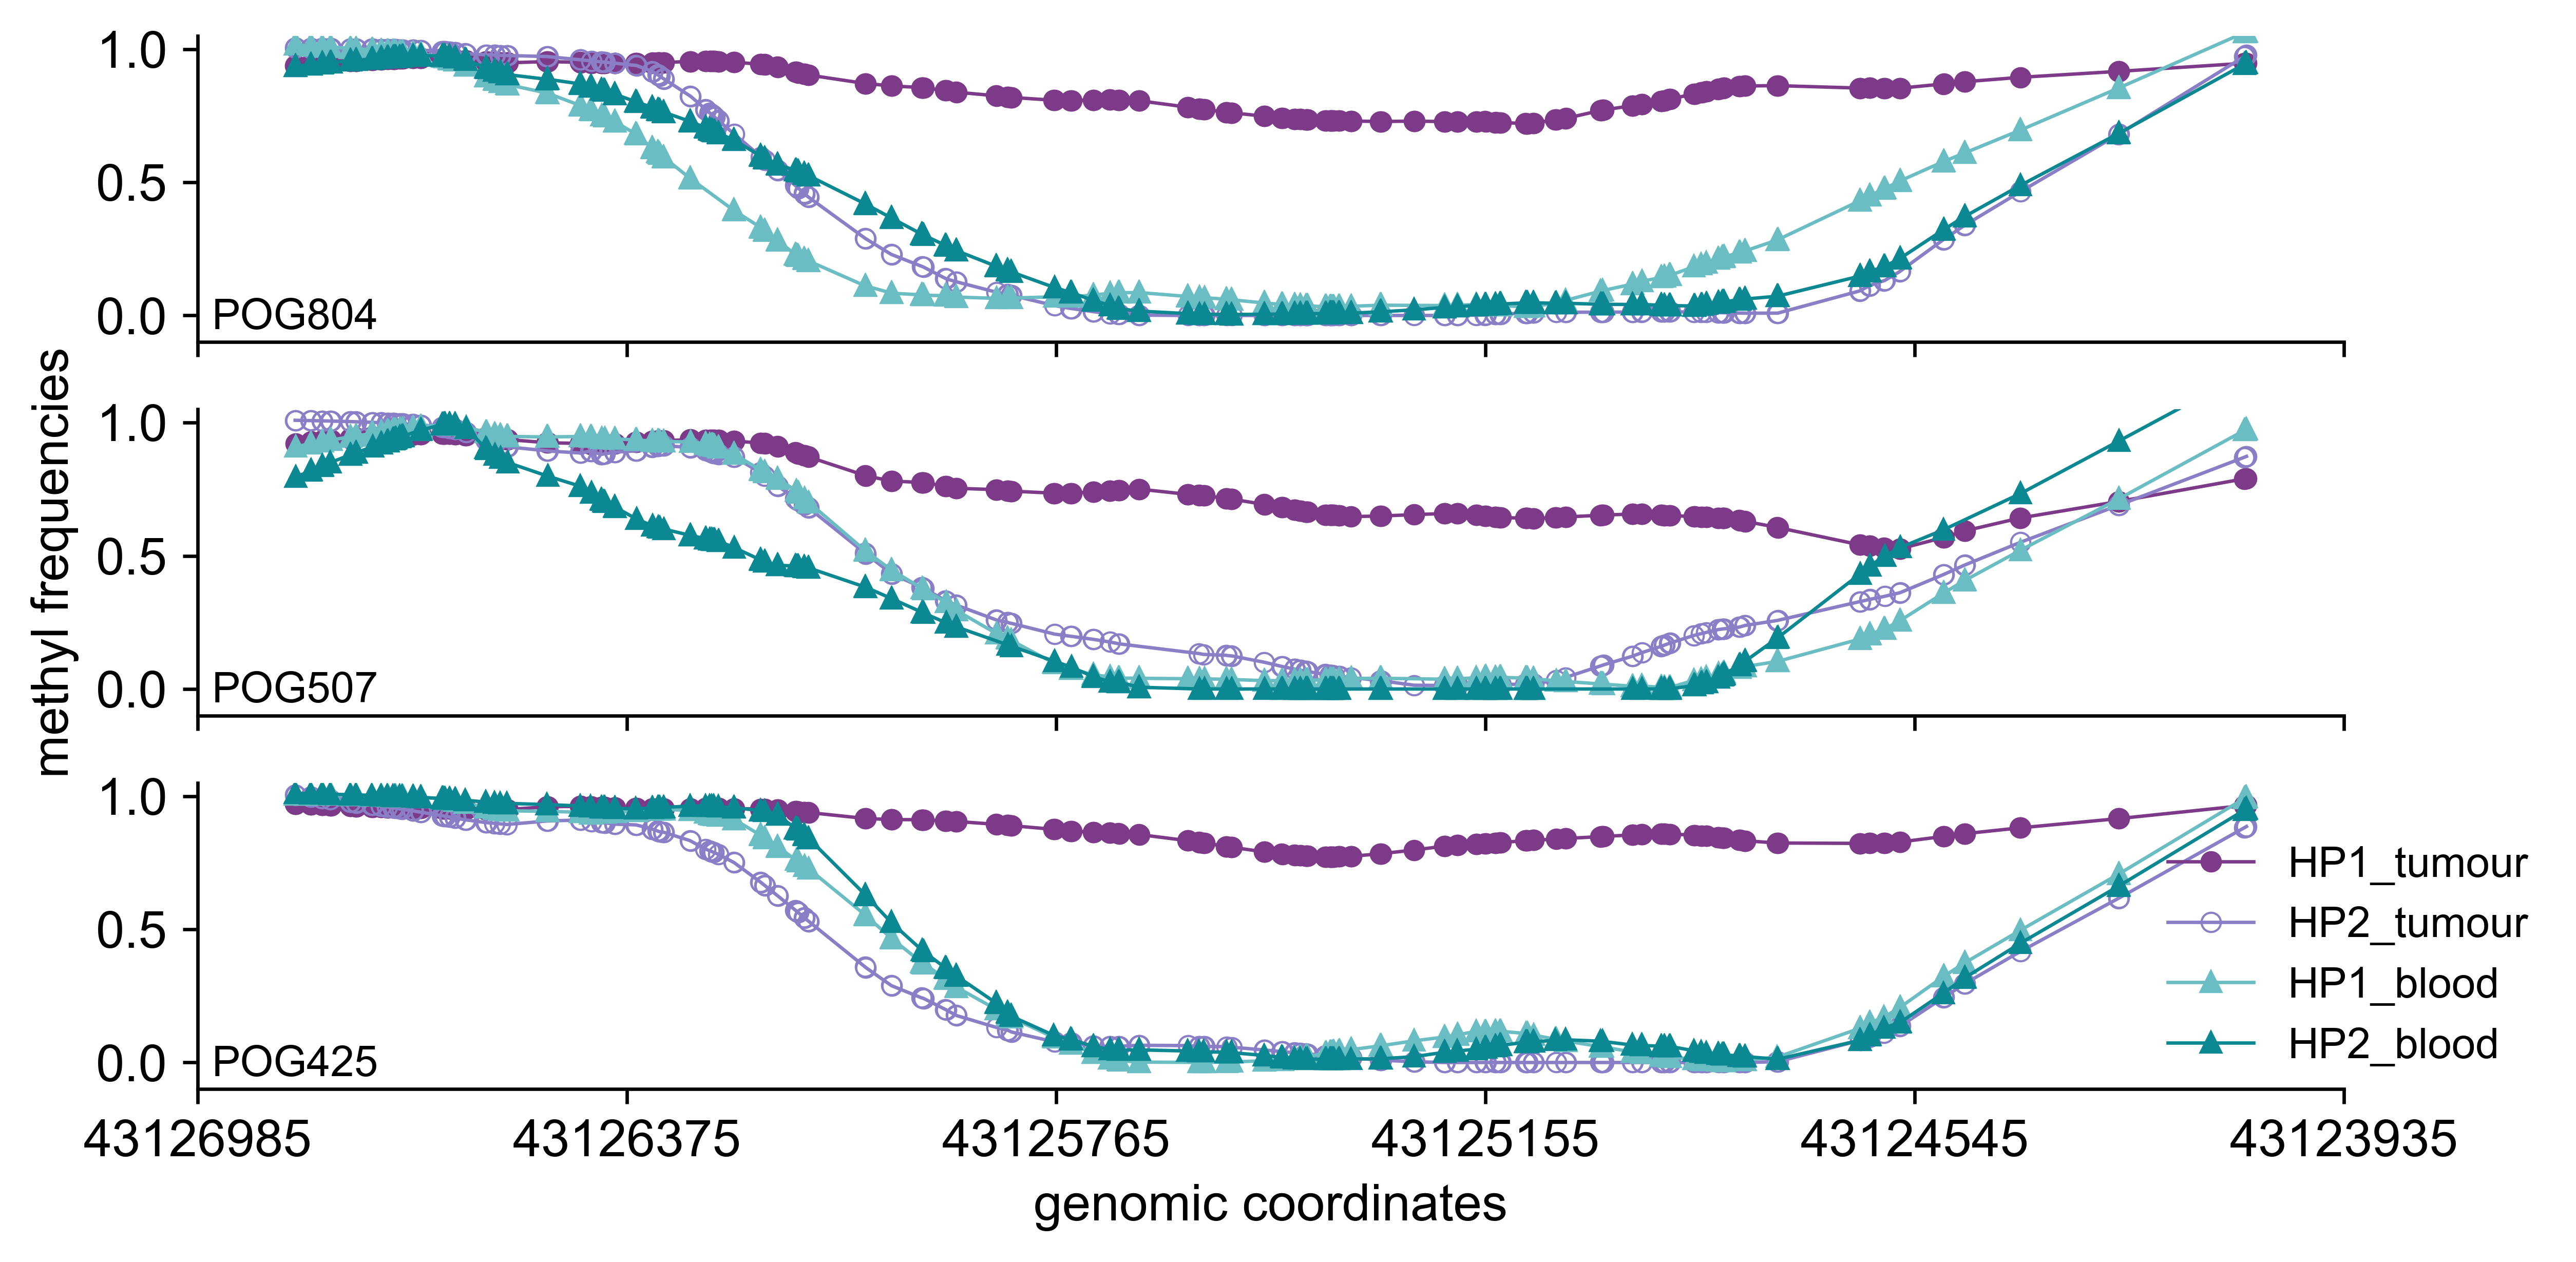

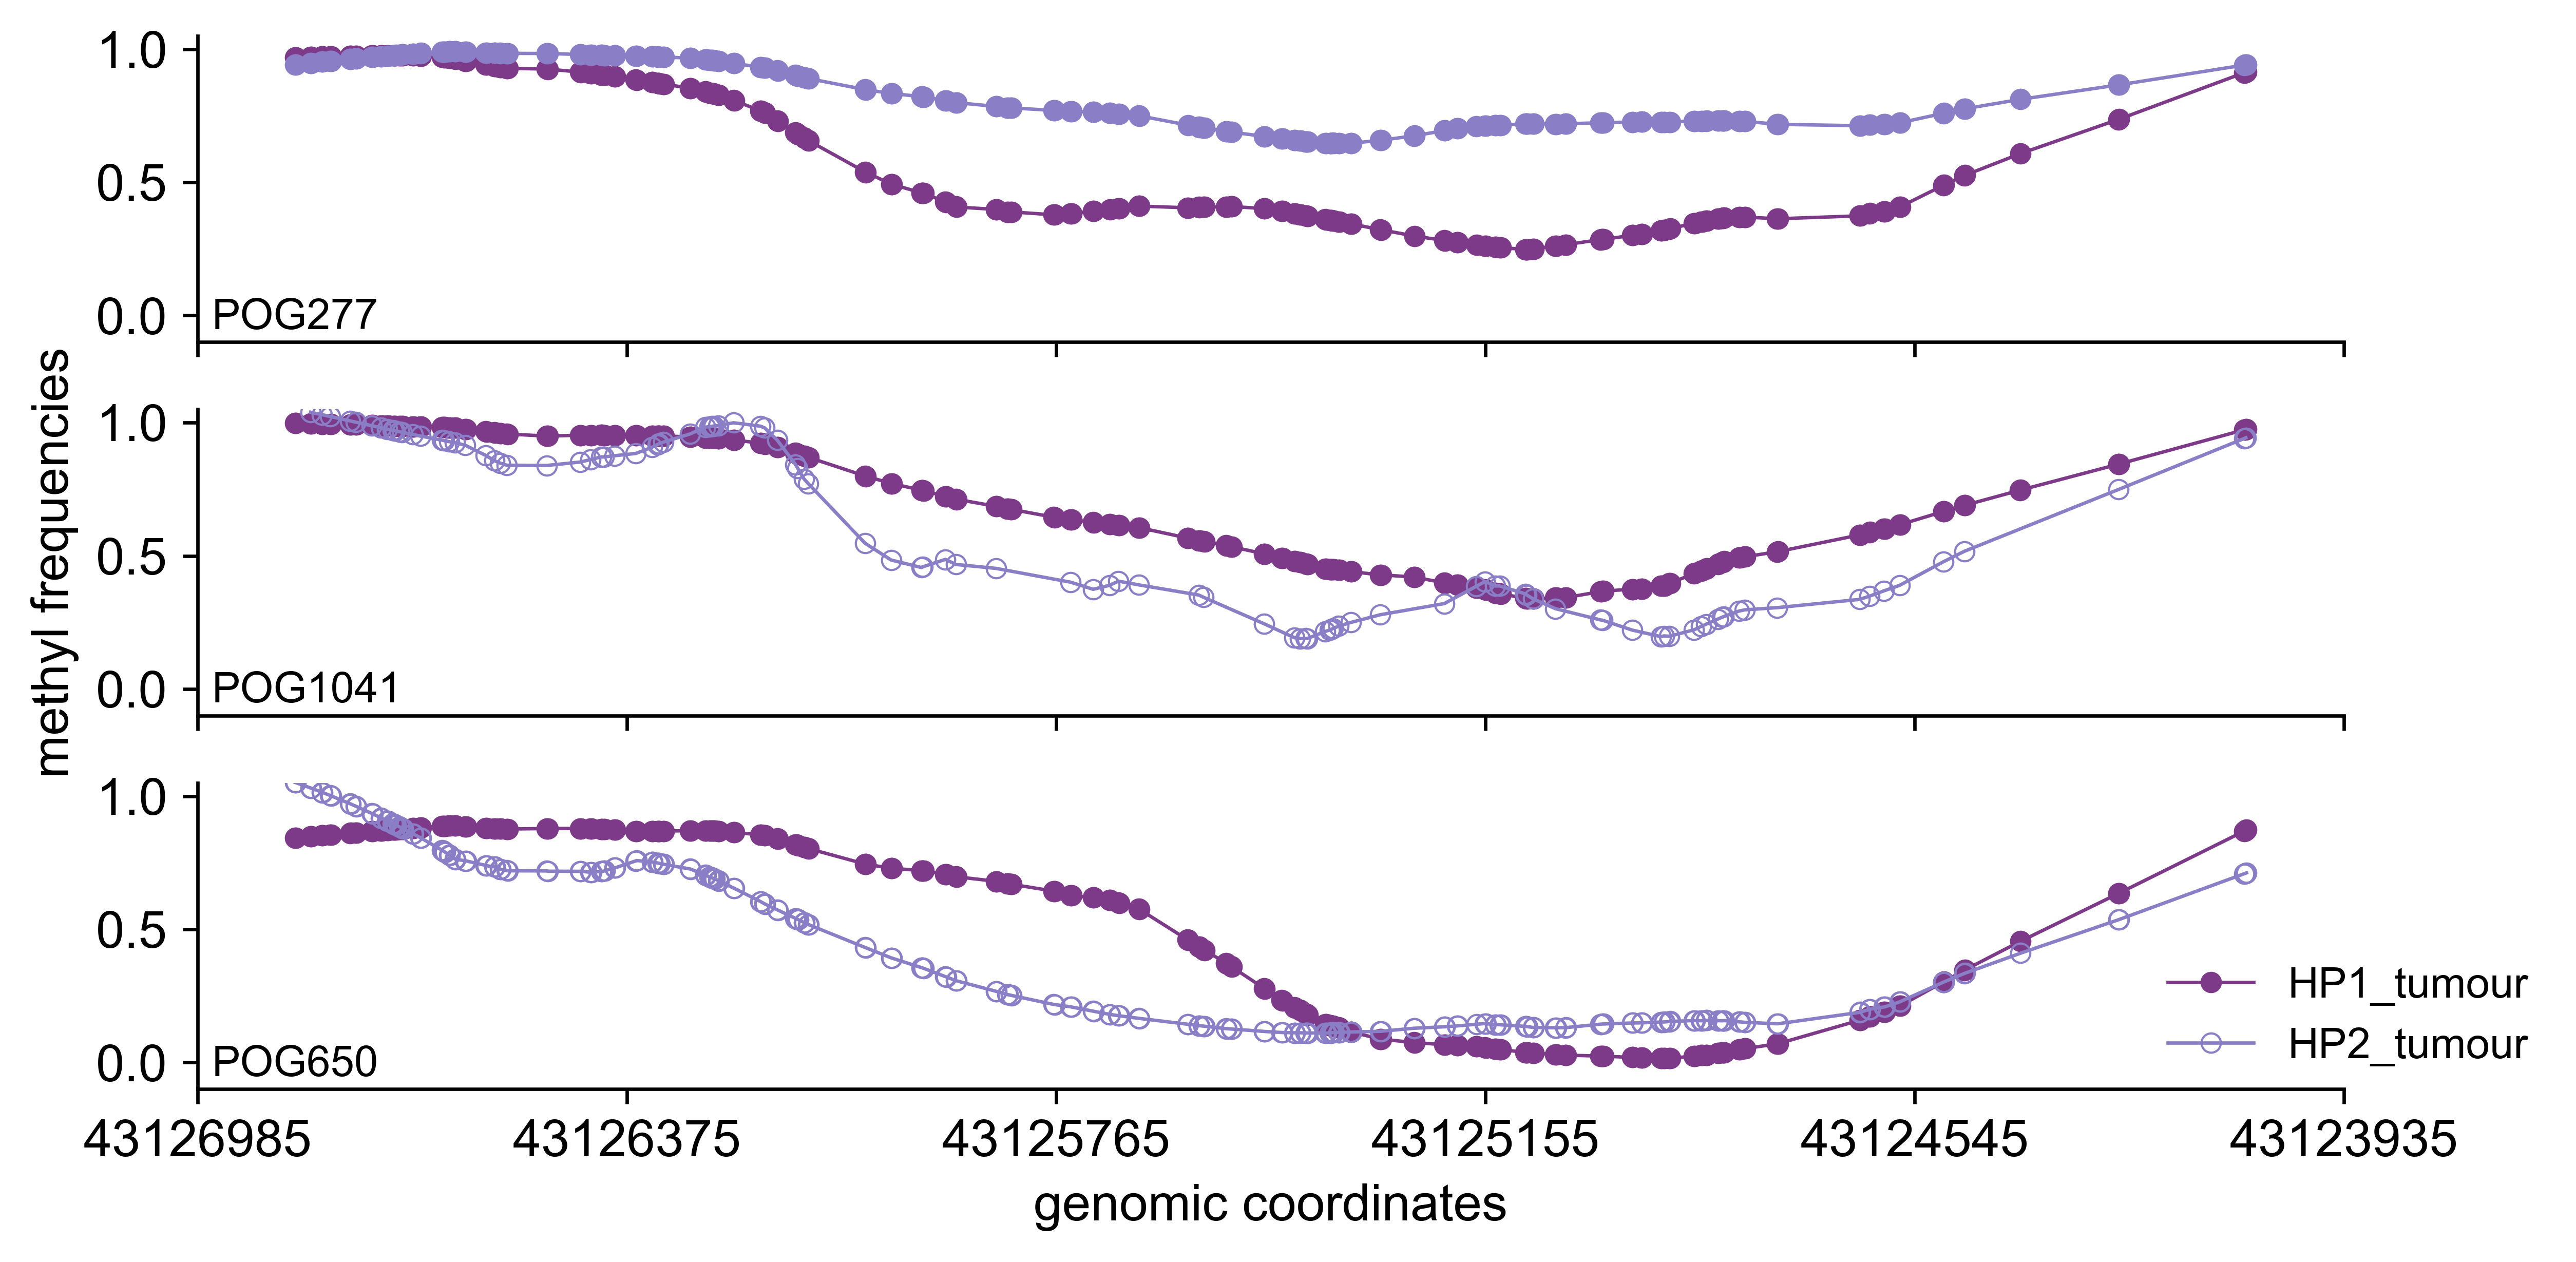

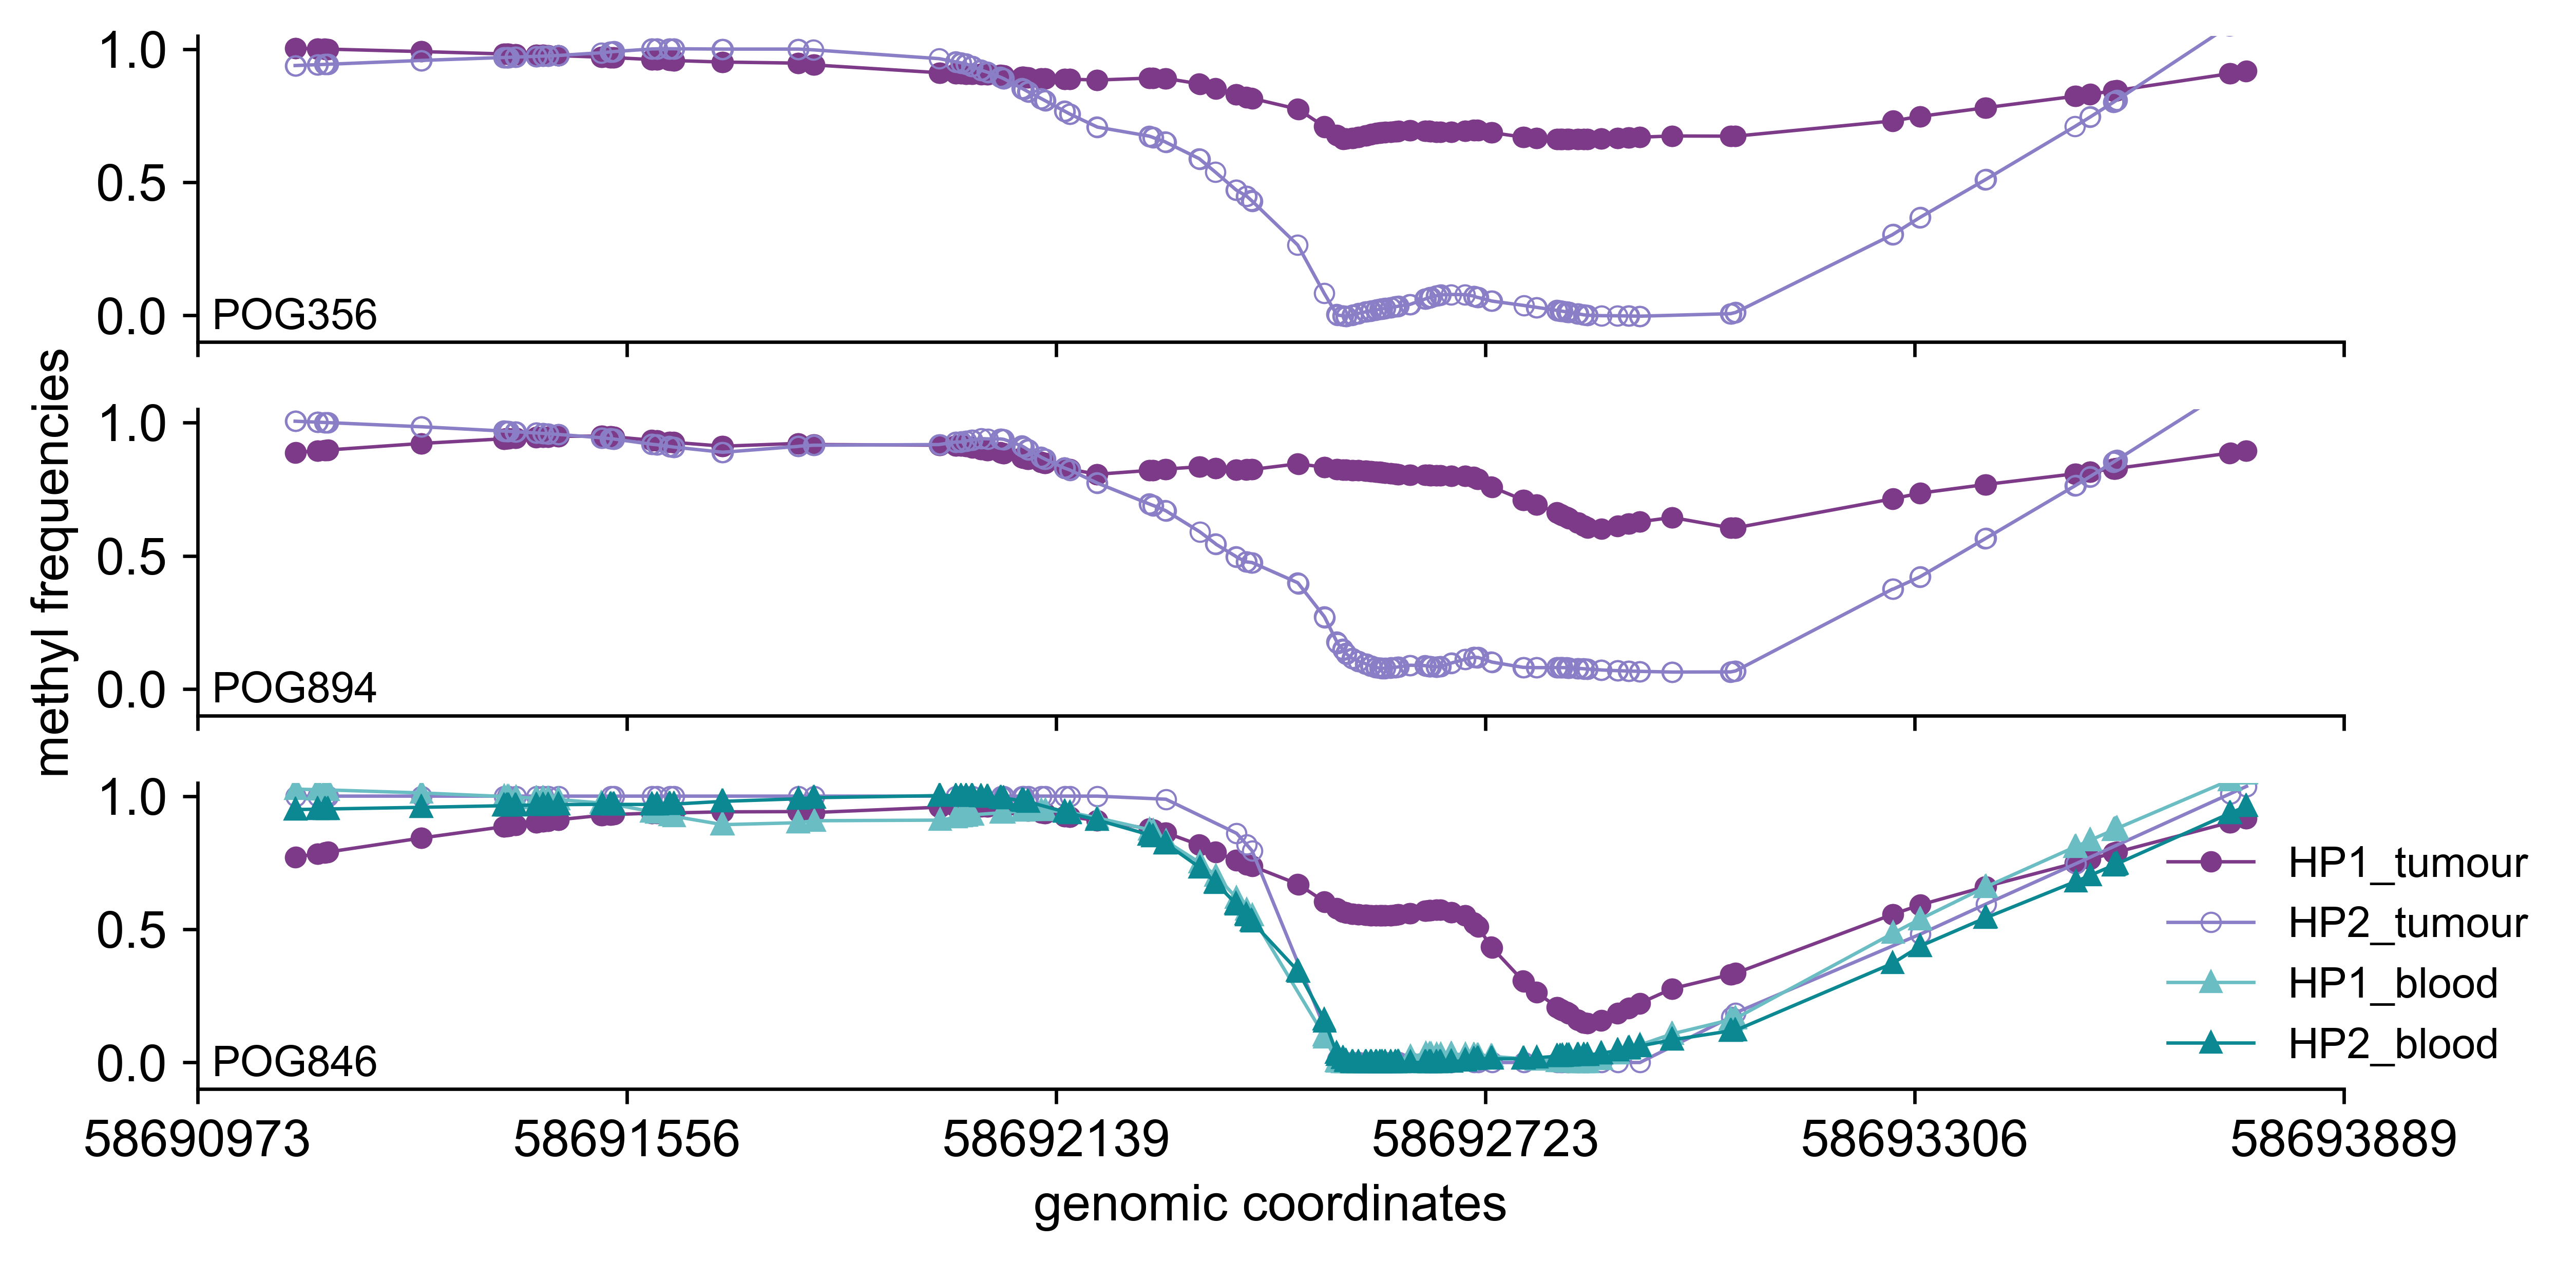

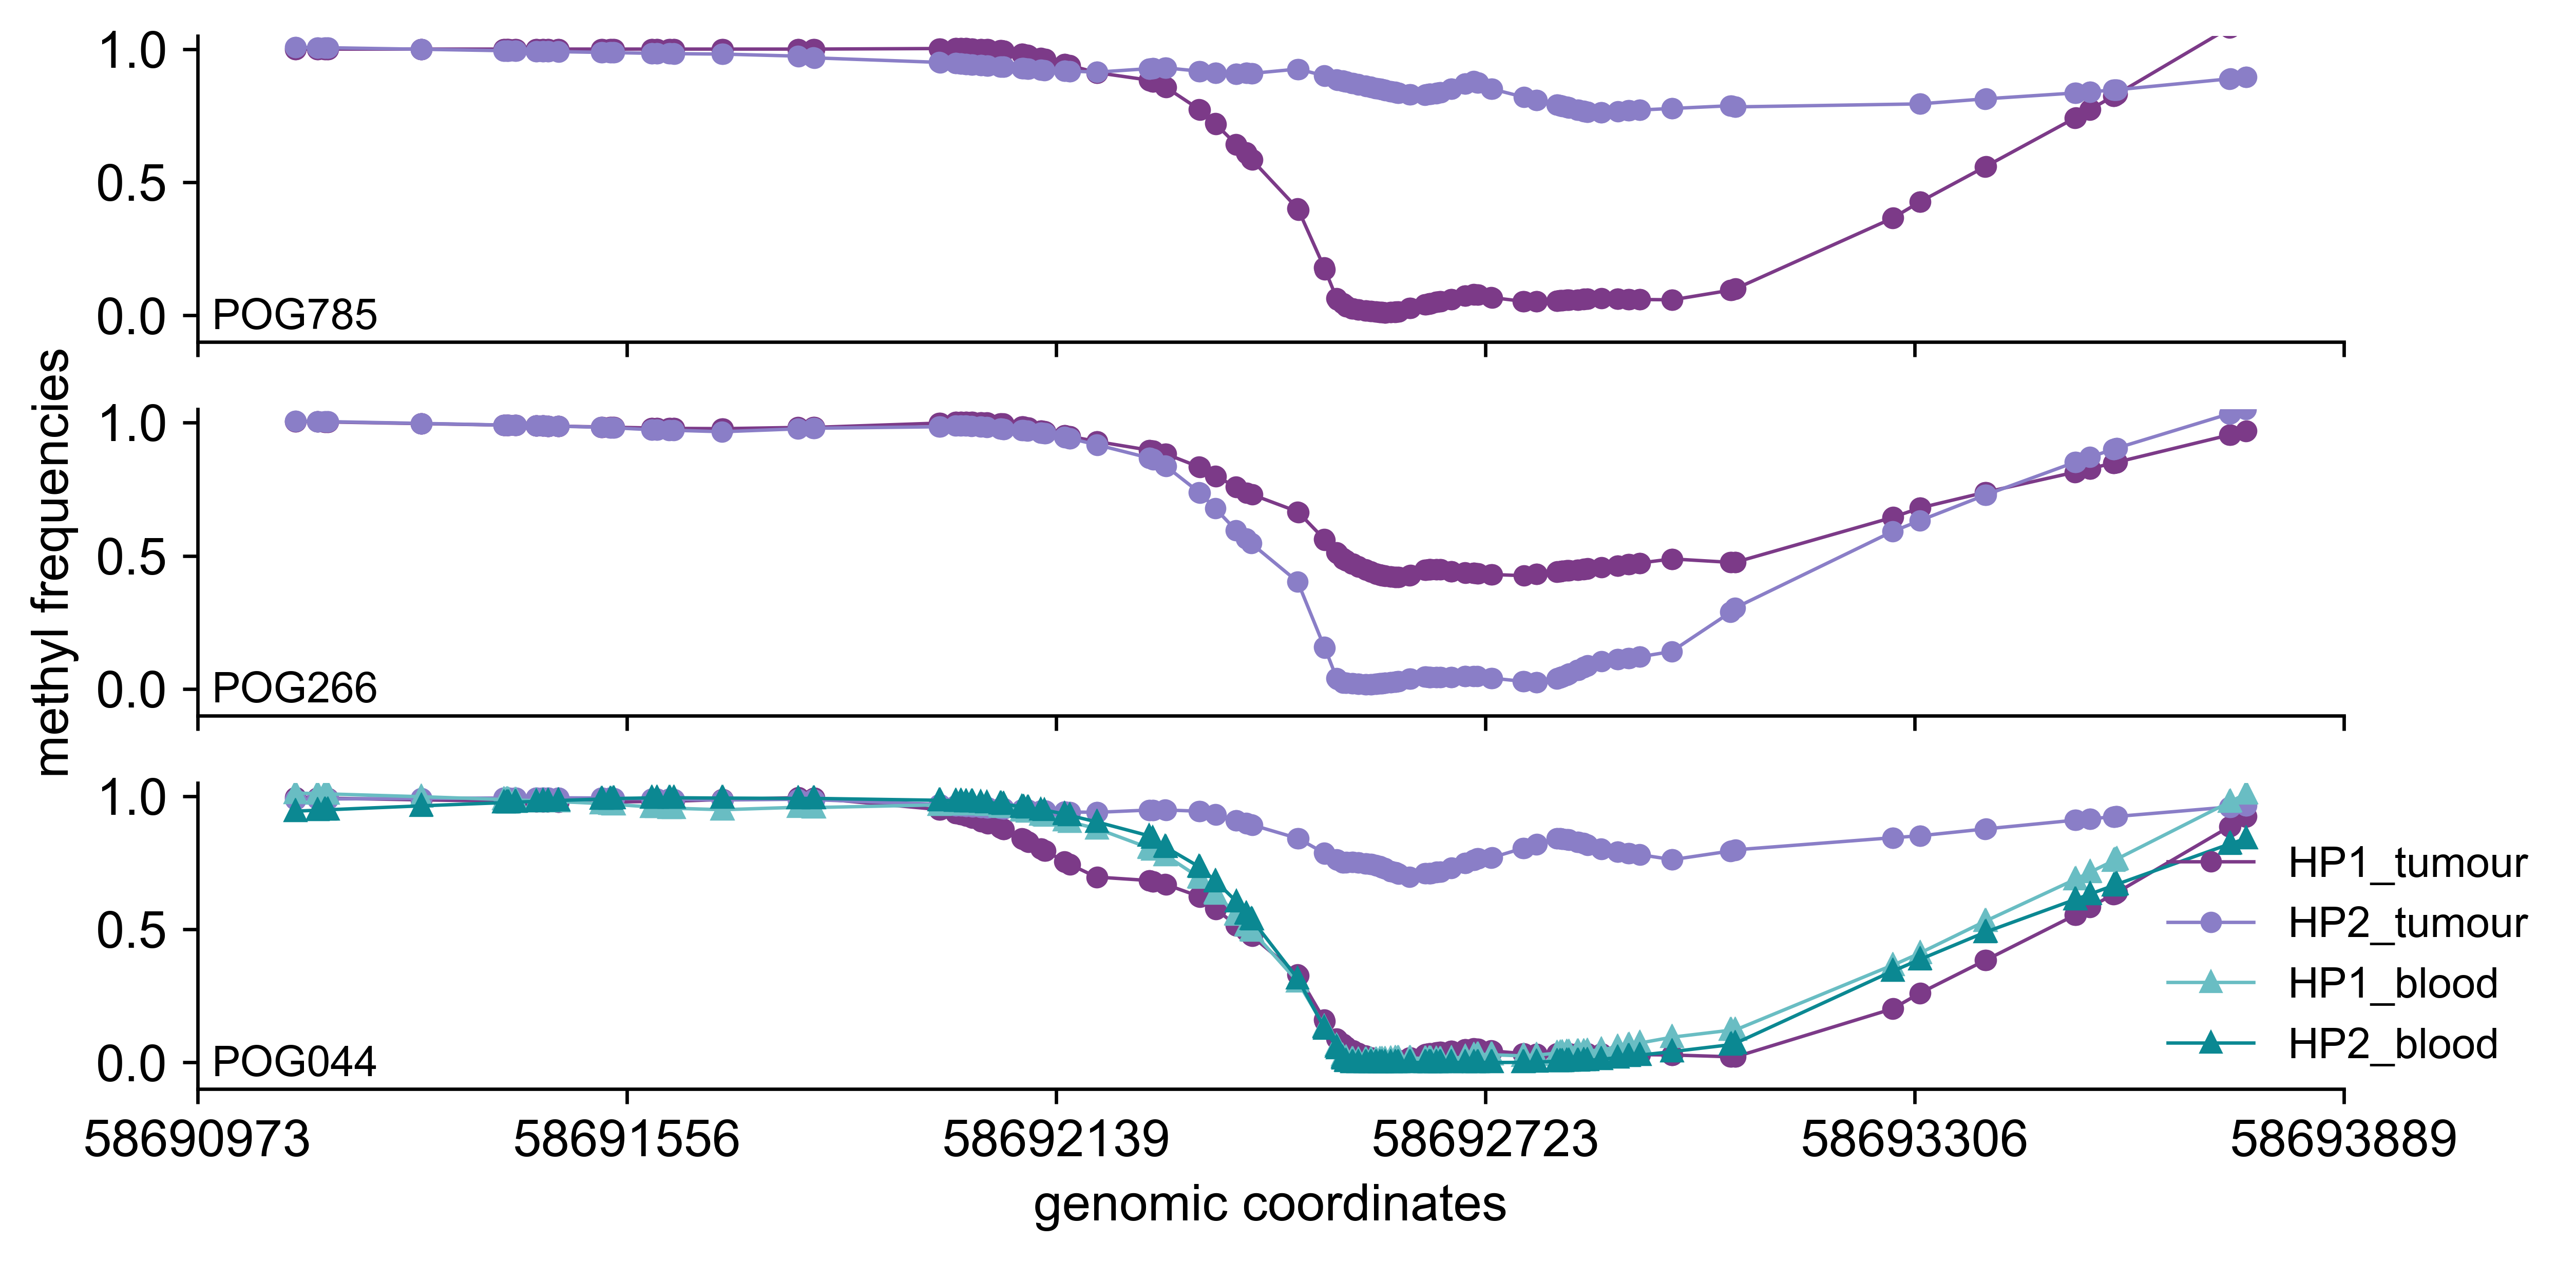

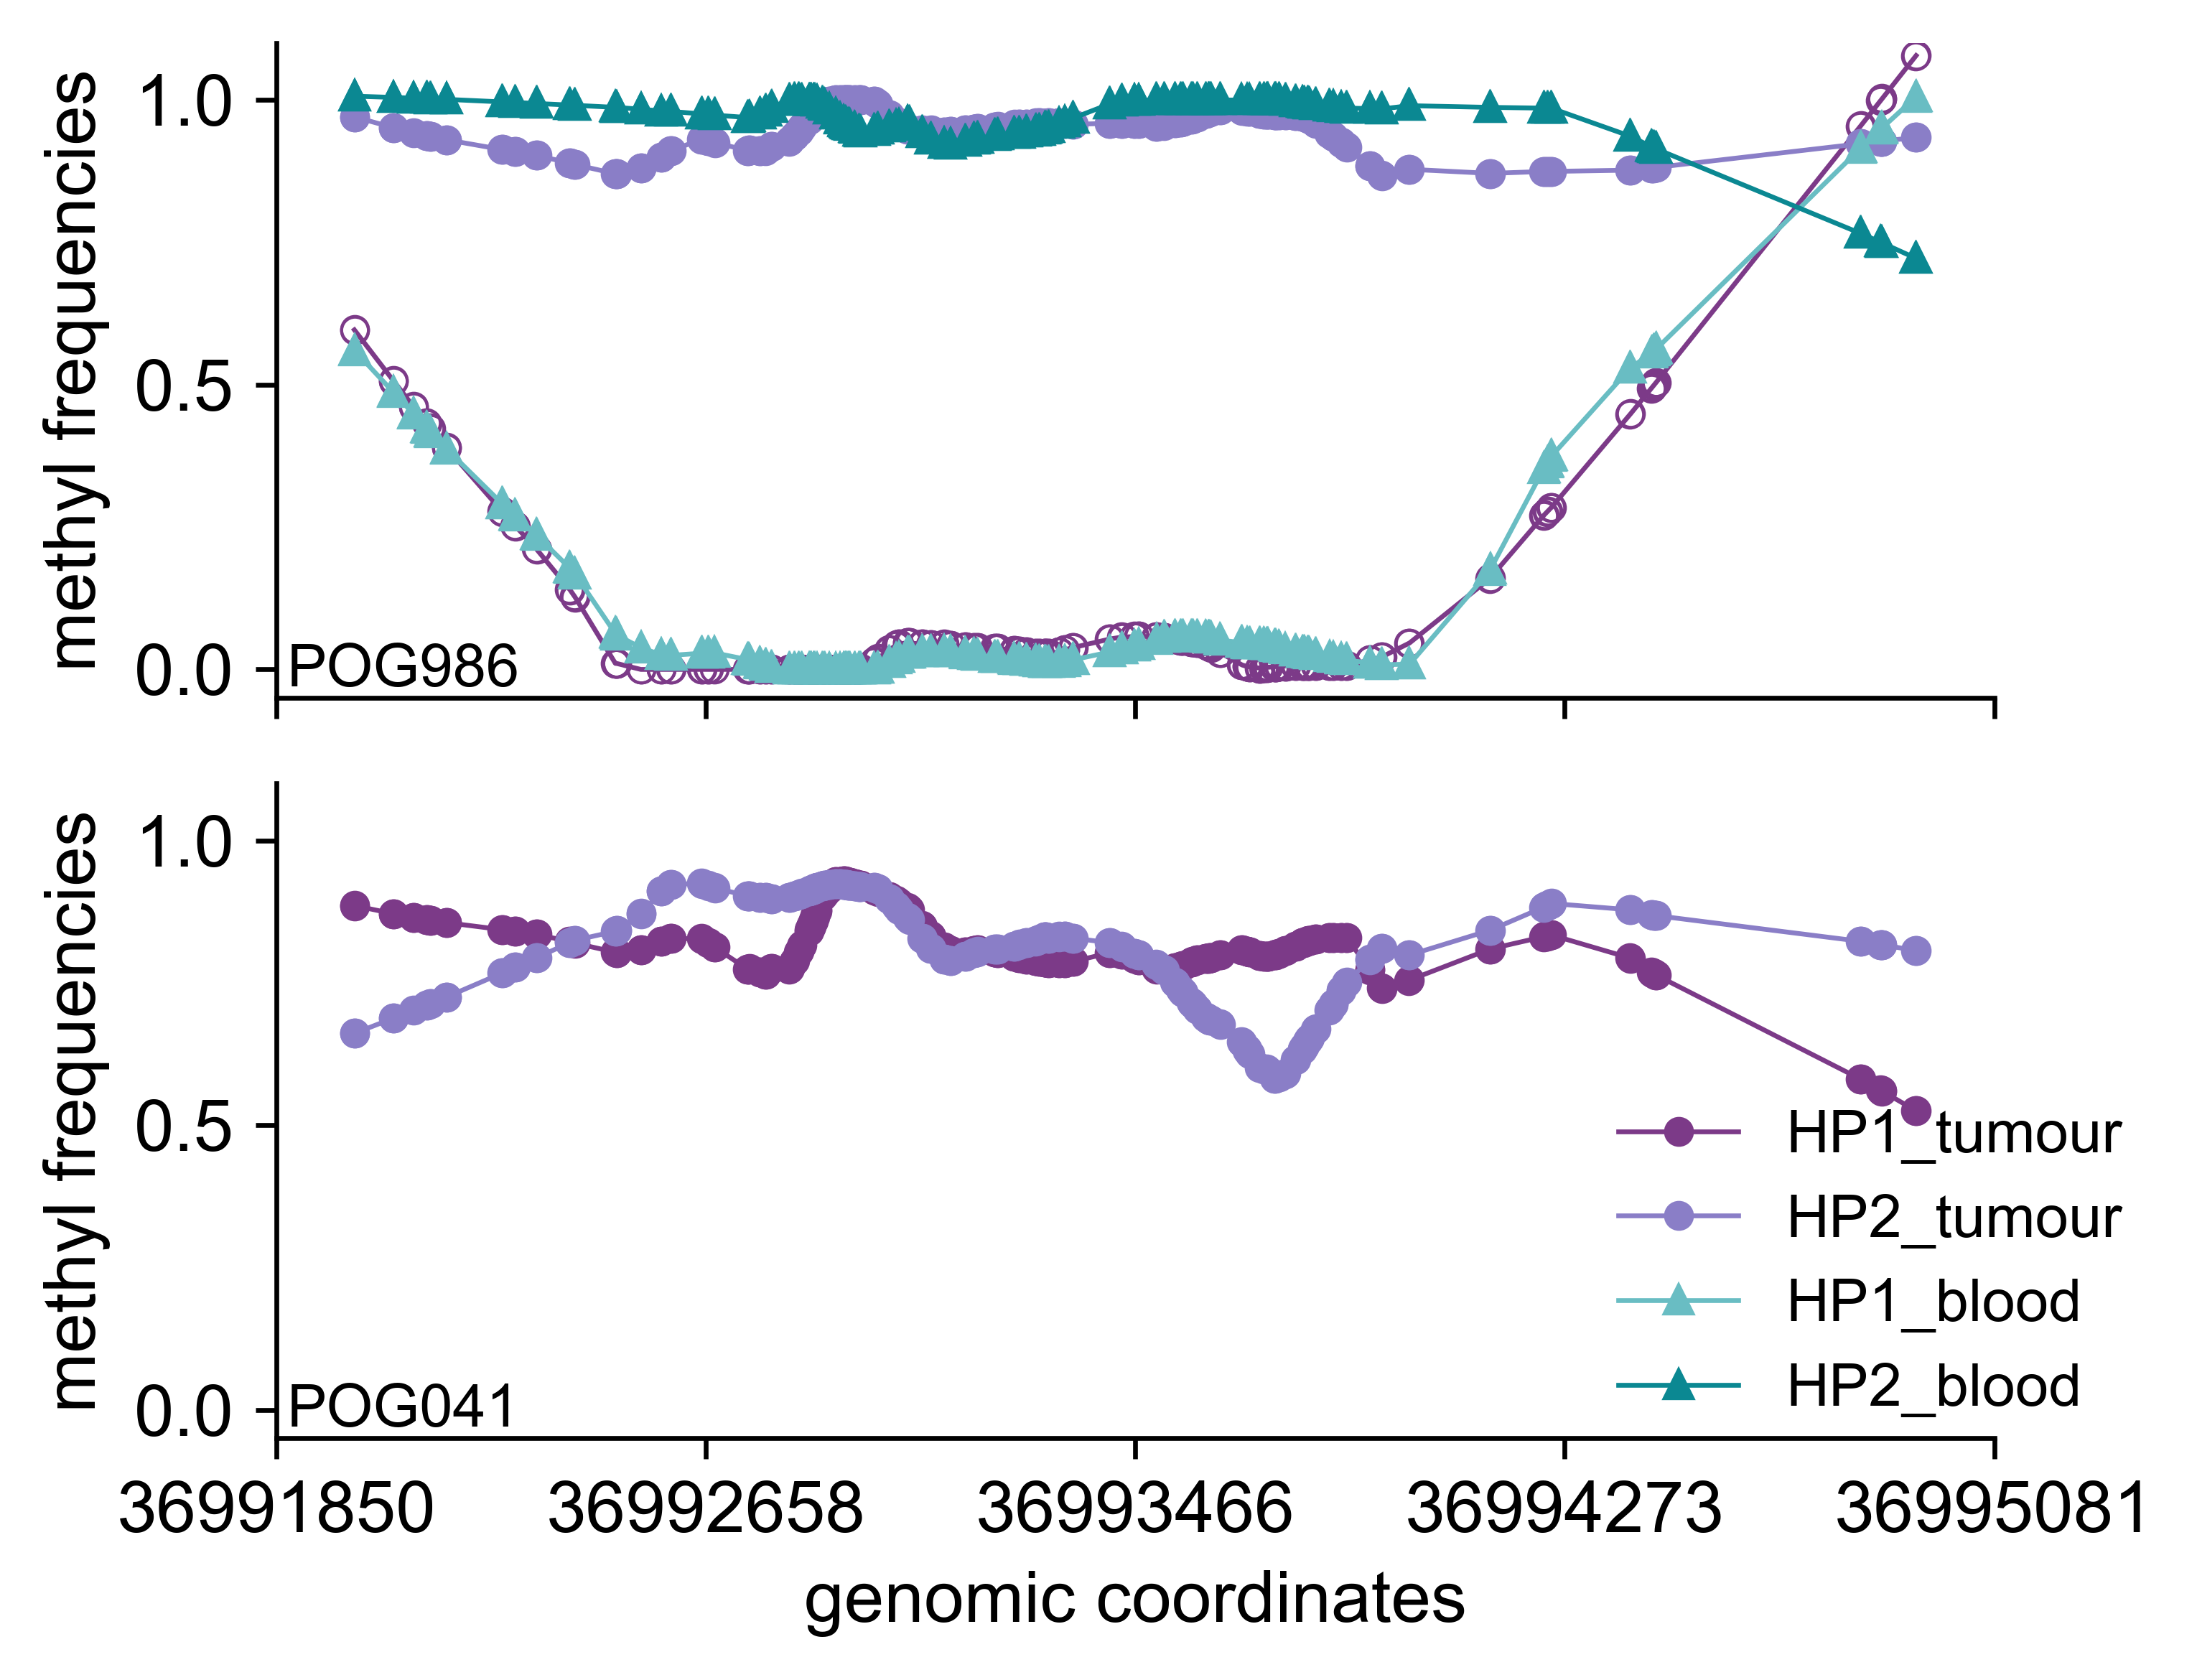

In [5]:
def main():
    
    ### BRCA1 Fig 5c
    filename_BRCA1_BRC_OVA_blood = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation/BRCA1_blood_haplotype_methyl_freq_BRC_OVA.tsv"
    filename_BRCA1_BRC_OVA_tumour = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation/BRCA1_tumour_haplotype_methyl_freq_BRC_OVA.tsv"
    ### BRCA1 Ex Fig5b
    filename_BRCA1_non_BRC_OVA_blood = r""
    filename_BRCA1_non_BRC_OVA_tumour = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation//BRCA1_tumour_haplotype_methyl_freq_non_BRC_OVA.tsv"

    BRCA1_files = {"BRC_OVA": [filename_BRCA1_BRC_OVA_blood, filename_BRCA1_BRC_OVA_tumour], 
                  "non_BRC_OVA":[filename_BRCA1_non_BRC_OVA_blood, filename_BRCA1_non_BRC_OVA_tumour]}


    generate_BRCA1_haplotype_plots(BRCA1_files, BRCA1_METHYLATED_CASES_BRC_OVA, BRCA1_METHYLATED_CASES_NON_BRC_OVA, BRCA1_LOH_CASES)

    ### RAD51C Fig 5d
    filename_RAD51C_BRC_OVA_blood = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation/RAD51C_blood_haplotype_methyl_freq_BRC_OVA.tsv"
    filename_RAD51C_BRC_OVA_tumour = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation/RAD51C_tumour_haplotype_methyl_freq_BRC_OVA.tsv"
    ### RAD51C Ex Fig5c
    filename_RAD51C_non_BRC_OVA_blood = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation/RAD51C_blood_haplotype_methyl_freq_non_BRC_OVA.tsv"
    filename_RAD51C_non_BRC_OVA_tumour = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation/RAD51C_tumour_haplotype_methyl_freq_non_BRC_OVA.tsv"
   
    RAD51C_files = {"BRC_OVA": [filename_RAD51C_BRC_OVA_blood, filename_RAD51C_BRC_OVA_tumour], 
                  "non_BRC_OVA":[filename_RAD51C_non_BRC_OVA_blood, filename_RAD51C_non_BRC_OVA_tumour]}

    
    generate_RAD51C_haplotype_plots(RAD51C_files, RAD51C_METHYLATED_CASES_BRC_OVA, RAD51C_METHYLATED_CASES_NON_BRC_OVA, RAD51C_LOH_CASES)

    ### MLH1 Fig 5f
    filename_MLH1_blood = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation/MLH1_blood_haplotype_methyl_freq.tsv"
    filename_MLH1_tumour = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation/MLH1_tumour_haplotype_methyl_freq.tsv"

    generate_MLH1_haplotype_plots(filename_MLH1_blood, filename_MLH1_tumour, MLH1_METHYLATED_CASES, MLH1_LOH_CASE)

if __name__ == "__main__":
    try:
        main()
    except Exception as err:
        logger.critical("Failure: %s", err, exc_info=True)